In [1]:
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import random
import torch.nn.functional as F

In [2]:
def read_bird_names(fname):
    names = []
    with open(fname, 'r') as fp:
        next(fp)
        for line in fp:
            if ",Aves," in line:
                toks = line.split(',')
                try:
                    name = toks[17].lower()
                    #remove any non a-z, apostrophe or space
                    name = re.sub(r'[^a-z\s]', '', name)
                    name = re.sub(r'\s+', '_', name)
                    name = name.strip()
                    if len(name) > 3:
                        names.append(name)
                except:
                    pass
    return sorted(list(set(names)))
words = read_bird_names("/Users/satyajitgupte/code/birds/taxa_english.csv")
random.shuffle(words)

In [3]:
words[:3]

['rusty_mousewarbler', 'typical_stilts', 'wagtailtyrants']

In [4]:
chars = sorted(list(set(''.join(words))))
# +1 for .
sz = len(chars) + 1
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i,s in itos.items()}

In [5]:
def make_dataset(words, block_size=2):
    xs = []
    ys = []
    for word in words:
        #print(word)
        context = [0]*block_size
        for char in word + '.':
            ix = stoi[char]
            ys.append(ix)
            xs.append(context)
            #print(f"{''.join(itos[c] for c in context)}->{itos[ix]}")
            context = context[1:] + [ix]
    return torch.tensor(xs), torch.tensor(ys)

In [6]:
block_size = 8
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = make_dataset(words[:n1], block_size)
Xdev,Ydev = make_dataset(words[n1:n2], block_size)
Xte,Yte = make_dataset(words[n2:], block_size)

In [27]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join([itos[ix.item()] for ix in x]), '-->', itos[y.item()])

........ --> r
.......r --> u
......ru --> s
.....rus --> t
....rust --> y
...rusty --> _
..rusty_ --> m
.rusty_m --> o
rusty_mo --> u
usty_mou --> s
sty_mous --> e
ty_mouse --> w
y_mousew --> a
_mousewa --> r
mousewar --> b
ousewarb --> l
usewarbl --> e
sewarble --> r
ewarbler --> .
........ --> t


In [227]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn(fan_in, fan_out)/(fan_in**0.5) # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #batchnorm params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers trained with momentum updates
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)
        
    def __call__(self, x):
        
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            
            #batch mean and var
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [ p for layer in self.layers for p in layer.parameters()]
    
        

In [228]:
## heirarchical net - Wavenet
n_embed = 24
n_hidden = 128
model = Sequential([
    Embedding(sz, n_embed),
    FlattenConsecutive(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, sz),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weights *= 0.1
    
parameters = model.parameters()
for param in parameters:
    param.requires_grad = True
    
print("Num Params=", sum(p.nelement() for p in parameters))
    

    

Num Params= 76732


In [231]:
 # track stats
lossi = []
stepi = []
max_steps = 200000

# optimize
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:     
        param.data += -lr*param.grad
    if i % 10000 == 0:
        print("iter=", i, "loss=", loss.item())
    lossi.append(loss.item())
    stepi.append(i)
    #break

iter= 0 loss= 3.2930455207824707
iter= 10000 loss= 1.2640882730484009
iter= 20000 loss= 1.0742664337158203
iter= 30000 loss= 1.4870531558990479
iter= 40000 loss= 1.7088806629180908
iter= 50000 loss= 1.6861320734024048
iter= 60000 loss= 1.0498051643371582
iter= 70000 loss= 1.171116828918457
iter= 80000 loss= 1.307023525238037
iter= 90000 loss= 1.0421415567398071
iter= 100000 loss= 1.2780659198760986
iter= 110000 loss= 1.3236794471740723
iter= 120000 loss= 0.5835496187210083
iter= 130000 loss= 0.9497001767158508
iter= 140000 loss= 0.7906080484390259
iter= 150000 loss= 0.9338932633399963
iter= 160000 loss= 0.9473894834518433
iter= 170000 loss= 0.919169008731842
iter= 180000 loss= 0.9080209732055664
iter= 190000 loss= 1.2584919929504395


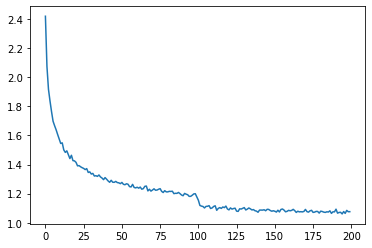

In [232]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [233]:
# put model in eval mode
for layer in model.layers:
    layer.training = False

In [234]:
@torch.no_grad
def evaluate_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(split, "Loss=", loss.item())

In [235]:
evaluate_loss("train")
evaluate_loss("dev")

train Loss= 1.009708046913147
dev Loss= 1.1073951721191406


In [239]:
g = torch.Generator().manual_seed(7)

for _ in range(25):
    ix = [0]*block_size
    out_ixs = []
    while True:
        logits = model([torch.tensor(ix).unsqueeze(0)])
        probs = F.softmax(logits, dim=1)
        ix_out = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ix.append(ix_out)
        ix = ix[1:]
        if ix_out == 0:
            break
        out_ixs.append(ix_out)
    print(''.join(itos[ix] for ix in out_ixs))

longs_bird
blyths_sclarfronted_honeyeater
rufousnaped_sparrow
guadalistlet
shycrid_hummingbird
whitethroated_drongo
hill_myzalthroated_whistlingthrush
greybabbler
ringnecked_whistler
maraintanager
clapper_tern
spicys_petrel
european_thrush
papuan_coot
flanked_warblingfinch_sunbird
canrumped_warblingfinch
paleafoots_turaco
northern
barteared_and_woodpecker
northern_whitecrested_tatria
frn_pygmyowl
whiteeared_cuckoo
biokaburranean_yellowthroat
vibbean_softtalagascar
cape_rail


In [240]:
model(Xtr[0].unsqueeze(0))

tensor([[-3.9893, -3.2665,  1.3275,  2.0832,  1.5966,  0.3612,  0.6387,  0.4369,
          1.7699,  0.6080,  0.2138, -0.7482, -0.0958,  0.9020,  1.3929,  0.7755,
         -0.2123,  1.3687, -2.9171,  1.4095,  1.9773,  1.1051, -1.7510, -0.3873,
          1.2970, -3.6778,  0.4684, -2.0793]], grad_fn=<AddBackward0>)

In [241]:
model(Xtr[1:2])

tensor([[-4.5755, -0.9333,  3.9662, -1.4714,  0.4321, -1.2061,  6.0850, -3.4826,
         -0.1625,  1.1867,  4.6624, -2.1549, -1.2710, -1.0676,  1.3248, -0.6198,
          4.7746,  1.8149, -3.9266, -0.9567, -0.6550, -2.1981,  6.2436, -3.5506,
          0.8276, -3.9038,  1.2628, -0.4756]], grad_fn=<AddBackward0>)

In [129]:
flattened.shape

torch.Size([1, 4, 8])

In [131]:
z1 = flattened @ torch.randn(8, 10)

In [132]:
z1.shape

torch.Size([1, 4, 10])

In [72]:
torch.all(torch.cat((e(x1)[0::2], e(x1)[1::2])) == f(e(x1)))

RuntimeError: The size of tensor a (4) must match the size of tensor b (8) at non-singleton dimension 2

In [112]:
v1 = torch.cat((e(x1)[:,::2,:], e(x1)[:,1::2,:]), dim=2)

In [114]:
torch.all(v1 == f(e(x1)))

tensor(True)

In [113]:
v1.shape

torch.Size([4, 4, 8])

In [106]:
f(e(x1)).shape

torch.Size([4, 4, 8])